# scRNAseq downstream analysis

Based on Jupyter Notebook created by Lauren Sanders.

### Updates:

1. Wrote script to zip all downloaded samples and give possibility to open as adata
2. Wrote script to modify marker table and adapted to be read by ScoreCT
3. Prepared the function that will process and plot all data that are needed to visualization - the function is also written to be easily incorporated with Django (system that is used on Viz Portal)
4. Finished cell type annotation with scoreCT - it works properly, when good markers are provided.
5. Found tools for DE analysis: I will test them in next update; Python: diffxpy, PyDESeq2, R: DESeq2 - I will compare them together
6. added optional function to run mt filtering step - works on booleans
7. it is possible to interactively compare multiple samples/tissues/genes at the same time - I have to face with scalability challenges and probably I need to move all plots to separate function / script

### Updates:
1. added sample_name marker to identify samples in adata
2. Removed basic filtering with fixed thresholds: 300genes and min. 3 cells. Instead of added dynamic threshold for 5th percentile of cells and 1st percentile of genes

#### Updates:
1. I have to check the code again because UMAP results are different that I expected - despite the same code, they vary from reference notebook I received.
2. Plot titles in violin and highly variable genes does not work
3. I have to prepare one more function for summary table - the last summary table is not good as I wanted
4. I have to readapt function sc_process() - it must contain all optional processes and have all necessary functions to run from users interface.

Next step:
1. finish UMAP
2. DE analysis of sample
3. final table of results
4. Incorporation to Django code
   

#### Updates:
I found out that GeneMarkers.gmt are not working properly because of wrong file format. GMT file REQUIRES to have second column for "optional" information (such as NA) and must be TAB separated.

### Script: Zip all files for scanpy (optional):

In [8]:
# Set the working folder:
root_folder = './test/'

In [9]:
# Define the file extensions we are looking for
extensions = ('.tsv', '.mtx')
#load libraries:
import os
import gzip
import shutil
# Function to find and zip files
def zipper(root_folder):
 
    # Walk through the directory, including subdirectories
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file is in a 'filtered' subdirectory:
            if 'filtered' in root:
                # Check for the desired file extension:
                if file.endswith(extensions):
                    file_path = os.path.join(root, file)
                    output_path = file_path + '.gz'  # Create the .gz filename
                    
                    # Zip the file:
                    with open(file_path, 'rb') as f_in:
                        with gzip.open(output_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    
                    print(f"Successfully zipped: {file_path} to {output_path}")
                else:
                    print(f"Skipping non-target file: {file}")
#execute the function:
zipper(root_folder)

Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\features.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\matrix.mtx to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene\filtered\matrix.mtx.gz


### Script: prepare marker table for scoreCT (optional):

In [201]:
# Load libraries:
import pandas as pd

# Load inputs:
df_input = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers.csv'
df_output = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.gmt'
column_name = 'cellName'
column_gene = 'geneSymbol'

# Load data:
df = pd.read_csv(df_input)
df = pd.DataFrame(df)

# Select only cellName and geneSymbol:
df_selected = df[[column_name, column_gene]]

# Create new columns for each representing gene:
df_split = df_selected[column_gene].str.split(',', expand=True)

# Concatenate the "one" column with the newly split columns
df_result = pd.concat([df[[column_name]], df_split], axis=1)

# Add the second column with "na" values
df_result.insert(1, 'na_column', 'na')

# Save results as tab-delimited file:
df_result.to_csv(df_output, sep='\t', header=False, index=False)


### Downstream analysis - chunk by chunk:

#### Load libraries (optional):

In [392]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import os
import sys
import scanpy as sc
import scorect as ct
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.8 pynndescent==0.5.13


#### Module0: Run functions:

#### Module1: input_data.py

In [605]:
#define basic path:
base_path = './test'

# find all subdirectories:
'''This script uses a loop to find all subdirectories
of working directory that contain scRNAseq datasets.

'''
out = []
for root, dirs, files in os.walk(base_path):
    # it was a problem with catching invisible folders, fixed it:
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    # Check if the current directory matches the filtered path
    if 'filtered' in root.split(os.sep):
         out.append(root)
out

#load first input for adata:
input_path=out[0]

#scanPy marker path
marker_file = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.gmt'

#load AnnData input file:
adata = sc.read_10x_mtx(input_path,var_names='gene_symbols',cache=True)

#define sample name from adata:
sample_name = os.path.basename(os.path.dirname(input_path))

#results file for processed adata:
results_file = sample_name + '_results_scoreCT.h5ad'

... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene-filtered-matrix.h5ad


In [523]:
adata

AnnData object with n_obs × n_vars = 9111 × 56748
    var: 'gene_ids', 'feature_types'

In [524]:
sample_name

'RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene'

#### Module2: parameters.py

In [586]:
"""
This script stores all necessary default parameters: 
"""

#Basic Filtering parameters:
DEFAULT_GENES_PERCENTILE = 5

DEFAULT_CELLS_PERCENTILE = 1

#Parameters to plot Genes and Cells:
save_format = "png"
save_dpi = 300
genes_plot = True
cells_plot = True

#Parameters for Violin plots etc:
jitter_param = 0.4

#filter cells based on gene counts (basic is 2500):
filter_gene_counts = 2500

#### Module3: SaveData.py

In [614]:
import matplotlib.pyplot as plt  # Ensure this is imported

def SaveData(adata=None, genes_plot=None, cells_plot=None, mt_analysis=False, 
             genes_counts=None, total_counts=None, pct_counts_mt=None, 
             pct_mt_scatter=None, genes_counts_scatter=None, postNormplot = None):
    if adata is not None:
        adata.write(f"{sample_name}_filtered.h5ad")
        print(f"Filtered data saved to {sample_name}_filtered.h5ad")

    if genes_counts is not None:
        genes_counts.figure.savefig(f"{sample_name}_violin_genes_counts.{save_format}", dpi=save_dpi)
        print(f"Saved genes_counts plot as {sample_name}_violin_genes_counts.{save_format}")

    if total_counts is not None:
        total_counts.figure.savefig(f"{sample_name}_violin_total_counts.{save_format}", dpi=save_dpi)
        print(f"Saved total_counts plot as {sample_name}_violin_total_counts.{save_format}")

    if pct_counts_mt is not None:
        pct_counts_mt.figure.savefig(f"{sample_name}_violin_pct_counts_mt.{save_format}", dpi=save_dpi)
        print(f"Saved pct_counts_mt plot as {sample_name}_violin_pct_counts_mt.{save_format}")

    if pct_mt_scatter is not None:
        pct_mt_scatter.figure.savefig(f"{sample_name}_scatter_pct_mt.{save_format}", dpi=save_dpi)
        print(f"Saved pct_mt_scatter plot as {sample_name}_scatter_pct_mt.{save_format}")

    if genes_counts_scatter is not None:
        genes_counts_scatter.figure.savefig(f"{sample_name}_scatter_genes_counts.{save_format}", dpi=save_dpi)
        print(f"Saved genes_counts_scatter plot as {sample_name}_scatter_genes_counts.{save_format}")

    if postNormplot is not None:
        postNormplot.figure.savefig(f"{sample_name}HighlyExpressedGenes.{save_format}", dpi=save_dpi)
        print(f"Saved HighlyExpressedGenes plot as {sample_name}_HighlyExpressedGenes.{save_format}")

#### Module4: BasicFiltering.py

In [577]:
import numpy as np
import scanpy as sc

def BasicFiltering(genes_percentile=None, cells_percentile=None, save_data=False):
    """
    Filter cells and genes based on QC metrics.

    Parameters:
    - genes_percentile: Optional percentile for filtering genes (default is from parameters.py)
    - cells_percentile: Optional percentile for filtering cells (default is from parameters.py)

    Returns:
    - Filtered AnnData object
    """
    # Calculate QC metrics
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cdf = stat[0]
    gdf = stat[1]

    # Use user-specified percentiles or defaults
    genes_percentile = genes_percentile if genes_percentile is not None else DEFAULT_GENES_PERCENTILE
    cells_percentile = cells_percentile if cells_percentile is not None else DEFAULT_CELLS_PERCENTILE

    # Calculate thresholds
    genes = list(set(cdf['n_genes_by_counts']))
    cells = list(set(gdf['n_cells_by_counts']))

    gene_threshold = np.percentile(genes, genes_percentile)
    cell_threshold = np.percentile(cells, cells_percentile)

    # Save the thresholds in adata.uns
    adata.uns['gene_threshold'] = gene_threshold
    adata.uns['cell_threshold'] = cell_threshold
    
    print(f'Filter out cells expressing fewer than: {gene_threshold} genes ({genes_percentile}th percentile)')
    print(f'Filter out genes detected in fewer than: {cell_threshold} cells ({cells_percentile}th percentile)')

    # Save adata if requested
    if save_data:
        SaveData(adata=adata)
    return adata
    

In [606]:
BasicFiltering()

Filter out cells expressing fewer than: 251.5 genes (5th percentile)
Filter out genes detected in fewer than: 26.97 cells (1th percentile)


AnnData object with n_obs × n_vars = 9111 × 56748
    var: 'gene_ids', 'feature_types'
    uns: 'gene_threshold', 'cell_threshold'

#### Module5: plotCellsAndGenes.py
Plot 1 and 2: Distribution plot of genes vs cells and cells vs genes:

In [536]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

def plotCellsAndGenes(genes_plot=genes_plot, cells_plot=cells_plot, save_data=False):
  
    # Calculate QC metrics based on the filtered adata from BasicFiltering
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cell_qc_dataframe = stat[0]
    gene_qc_dataframe = stat[1]

    # Retrieve the filtering thresholds from the adata object after BasicFiltering
    gene_threshold = adata.uns.get('gene_threshold', None)
    cell_threshold = adata.uns.get('cell_threshold', None)
    
    if gene_threshold is None or cell_threshold is None:
        raise ValueError("Filtering thresholds not found in the adata object. Ensure BasicFiltering was run.")

    print(f'Gene threshold: {gene_threshold}')
    print(f'Cell threshold: {cell_threshold}')

    # Unique variables for plot data
    genes_plot_data = None
    cells_plot_data = None

    # Plot Number of Genes by Counts (only if genes_plot is True)
    if genes_plot:
        fig_genes, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for genes plot
        ax.hist(cell_qc_dataframe['n_genes_by_counts'], bins="sqrt")
        ax.set(xlabel='N genes', ylabel='N cells')
        ax.axvline(gene_threshold, color='red')
        ax.set_title("Number of genes by counts")
        plt.show()
        genes_plot_data = fig_genes  # Store figure for later use

    # Plot Number of Cells by Counts (only if cells_plot is True)
    if cells_plot:
        fig_cells, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for cells plot
        ax.hist([int(x) for x in gene_qc_dataframe['n_cells_by_counts'] if x != 0], bins="sqrt")
        ax.set(xlabel='N cells expressing > 0', ylabel='N genes')
        ax.axvline(cell_threshold, color='red')
        ax.set_title("Number of cells by counts")
        plt.show()
        cells_plot_data = fig_cells  # Store figure for later use
    
    if save_data:
       SaveData(genes_plot=genes_plot_data, cells_plot=cells_plot_data)

Gene threshold: 251.5
Cell threshold: 26.97


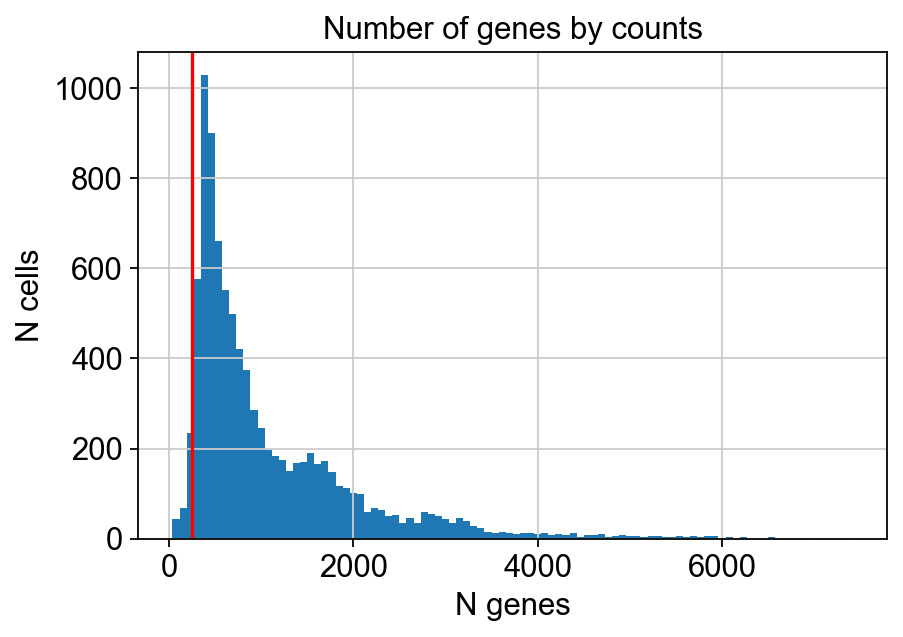

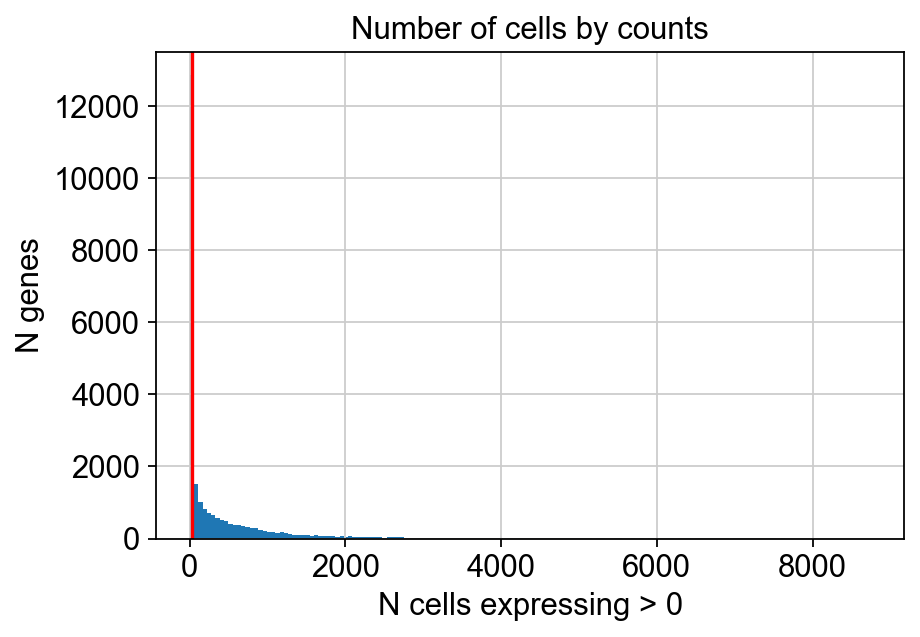

In [607]:
plotCellsAndGenes(save_data=True)

#### Module6: mtAnalysis.py
* Annotate mitochondrial genes (optional)

Identify the prefix of mt genes (classic scRNAseq analysis approach):

In [603]:
def mtAnalysis(analysis=True, save_mt=False):
    """
    Analyze mitochondrial gene content and calculate QC metrics.

    Parameters:
    - analysis: Boolean, whether to perform mitochondrial gene analysis (default: True)
    - save_mt: Boolean, whether to save the output of mitochondrial gene analysis (default: False)

    Returns:
    - Updated AnnData object with QC metrics.
    """
    if analysis:
        # Check for common mitochondrial gene prefixes in the first 50 gene names
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                # Annotate mitochondrial genes as "mt"
                adata.var["mt"] = adata.var_names.str.startswith(prefix)
                break
            # Add flag to indicate mitochondrial analysis was performed
            adata.uns['mt_analysis'] = True
        
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")
            adata.var["mt"] = False  # No mitochondrial genes found

        # Calculate QC metrics including mitochondrial genes
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
        print(f"Annotated mitochondrial genes and calculated QC metrics.")
    else:
        # Perform QC metrics calculation without mitochondrial gene annotation
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        print(f"Calculated QC metrics.")

    # Freeze current state for saving
    adata_frozen = adata.copy()

    # Save data if requested
    if save_mt:
        SaveData(adata=adata_frozen, mt_analysis=True)

    return adata

In [608]:
adata = mtAnalysis()

Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']
Annotated mitochondrial genes and calculated QC metrics.


#### Module7: plotViolin and plotScatter:
- title does not work

In [582]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotViolinScatter(genes_counts=True, total_counts=True, pct_counts_mt=True, pct_mt_scatter=True, genes_counts_scatter=True, save_data=False):
    """
    Plot violin and scatter plots for QC metrics.

    Parameters:
    - genes_counts: Whether to plot violin for "n_genes_by_counts" (default=True)
    - total_counts: Whether to plot violin for "total_counts" (default=True)
    - pct_counts_mt: Whether to plot violin for "pct_counts_mt" (default=True)
    - pct_mt_scatter: Whether to plot scatter for "pct_counts_mt" vs "total_counts" (default=True)
    - genes_counts_scatter: Whether to plot scatter for "n_genes_by_counts" vs "total_counts" (default=True)
    - save_data: Whether to save the generated plots (default=False)
    """
    plots_data = {}

    # Collect generated plots for saving
    genes_counts_fig = None
    total_counts_fig = None
    pct_counts_mt_fig = None
    pct_mt_scatter_fig = None
    genes_counts_scatter_fig = None
    
    # Violin plots
    if genes_counts:
        genes_counts_fig = sc.pl.violin(adata, "n_genes_by_counts", jitter=jitter_param, show=False)

    
    if total_counts:
        total_counts_fig = sc.pl.violin(adata, "total_counts", jitter=jitter_param, show=False)
       
    if pct_counts_mt:
        if "pct_counts_mt" in adata.obs:
            pct_counts_mt_fig = sc.pl.violin(adata, "pct_counts_mt", jitter=jitter_param, show=False)
           
    # Scatter plots
    if pct_mt_scatter:
        pct_mt_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
       
    if genes_counts_scatter:
        genes_counts_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
        
    # Save data if requested
    if save_data:
       SaveData(
           genes_counts=genes_counts_fig,
           total_counts=total_counts_fig,
           pct_counts_mt=pct_counts_mt_fig,
           pct_mt_scatter=pct_mt_scatter_fig,
           genes_counts_scatter=genes_counts_scatter_fig
       )

Saved genes_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_genes_counts.png
Saved total_counts plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_total_counts.png
Saved pct_counts_mt plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_violin_pct_counts_mt.png
Saved pct_mt_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_scatter_pct_mt.png
Saved genes_counts_scatter plot as RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_scatter_genes_counts.png


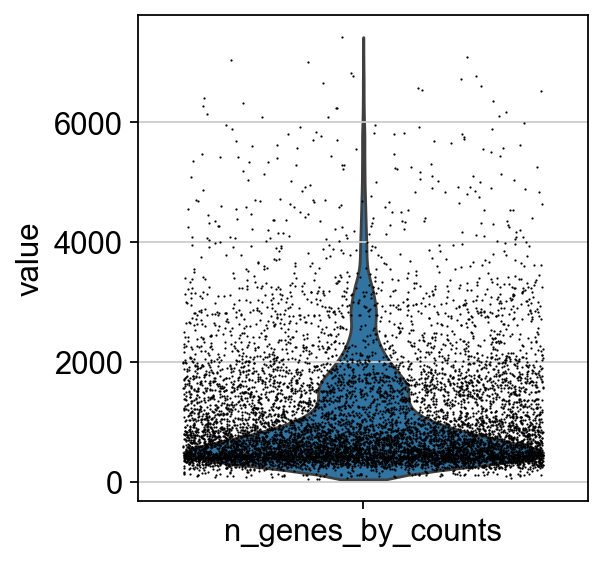

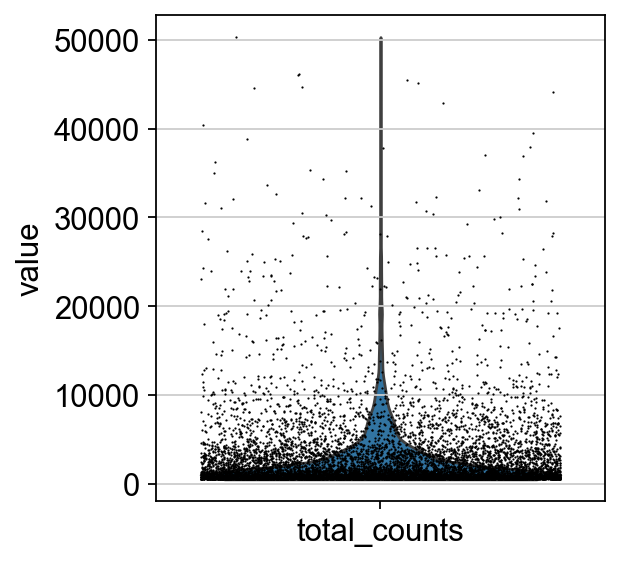

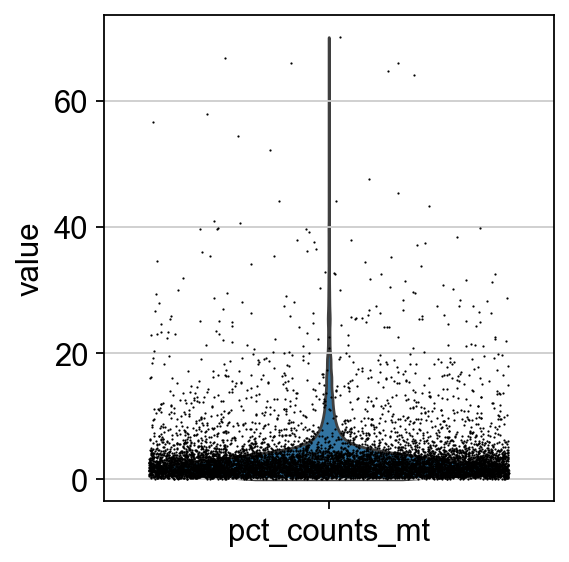

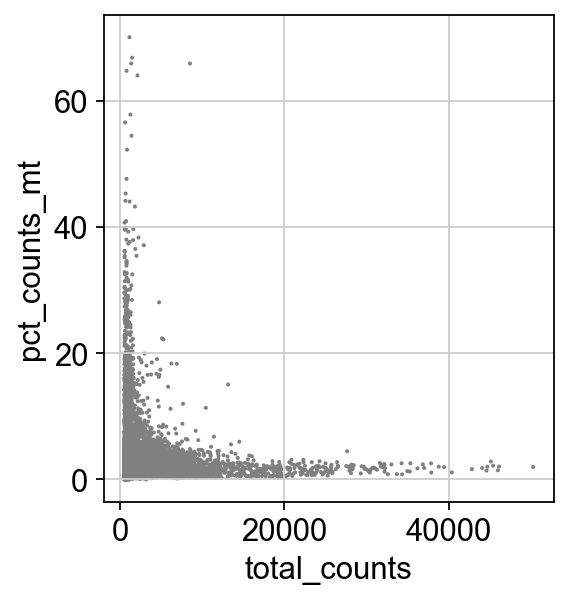

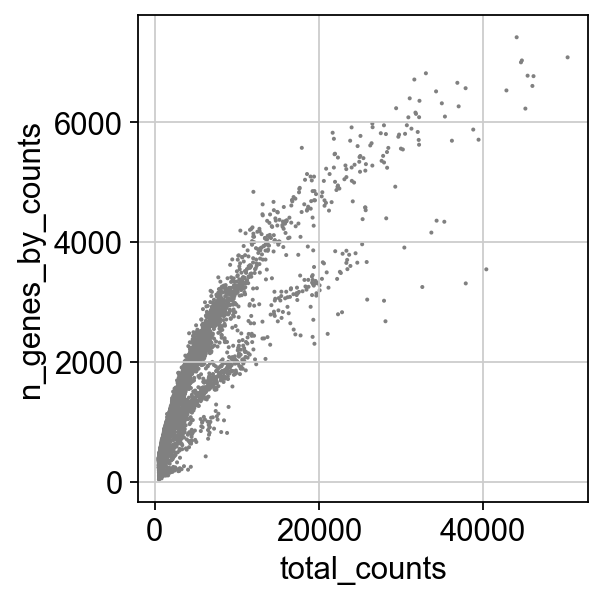

In [610]:
plotViolinScatter(save_data=True)

#### Filter cells based on gene counts:

In [611]:
#sub-module in main function (?):
if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True: 
    adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
    print(f"Filtered cells based on gene counts with mt_analysis.")
else:
    adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
    print(f"Filtered cells based on gene counts.")

Filtered cells based on gene counts with mt_analysis.


#### Module8: Normalization & Regress out:

In [612]:
import numpy as np
import scanpy as sc

def Normalization():
    """
    Normalize and preprocess the AnnData object.

    Returns:
    - Processed AnnData object.
    """
    global adata  # Ensure adata is accessible

    # Correct for library size:
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Perform log transformation:
    sc.pp.log1p(adata)

    # Identify highly variable genes:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # Freeze state:
    adata.raw = adata.copy()

    # Subset the data to include only highly variable genes:
    adata = adata[:, adata.var.highly_variable]

    # Check if mitochondrial analysis has been performed by checking adata.uns['mt_analysis']
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Regress out total counts and mitochondrial gene percentages
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        # Only regress out total counts if mitochondrial analysis wasn't run
        sc.pp.regress_out(adata, "total_counts")

    # Scale the data
    sc.pp.scale(adata, max_value=10)

    return adata

In [613]:
Normalization()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:41)


AnnData object with n_obs × n_vars = 7119 × 4173
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'gene_threshold', 'cell_threshold', 'mt_analysis', 'log1p', 'hvg'

#### Plot: post-normalization

In [615]:
def plotPostNormalization(save_data=False):
    
    global adata
    
    postNormplot = sc.pl.highest_expr_genes(adata, n_top=20)
    plt.suptitle(f"20 most highly expressed genes in sample: {sample_name}", fontsize=16)
    plt.show()

    
    if save_data:
        SaveData(postNormplot=postNormplot)

normalizing counts per cell
    finished (0:00:00)


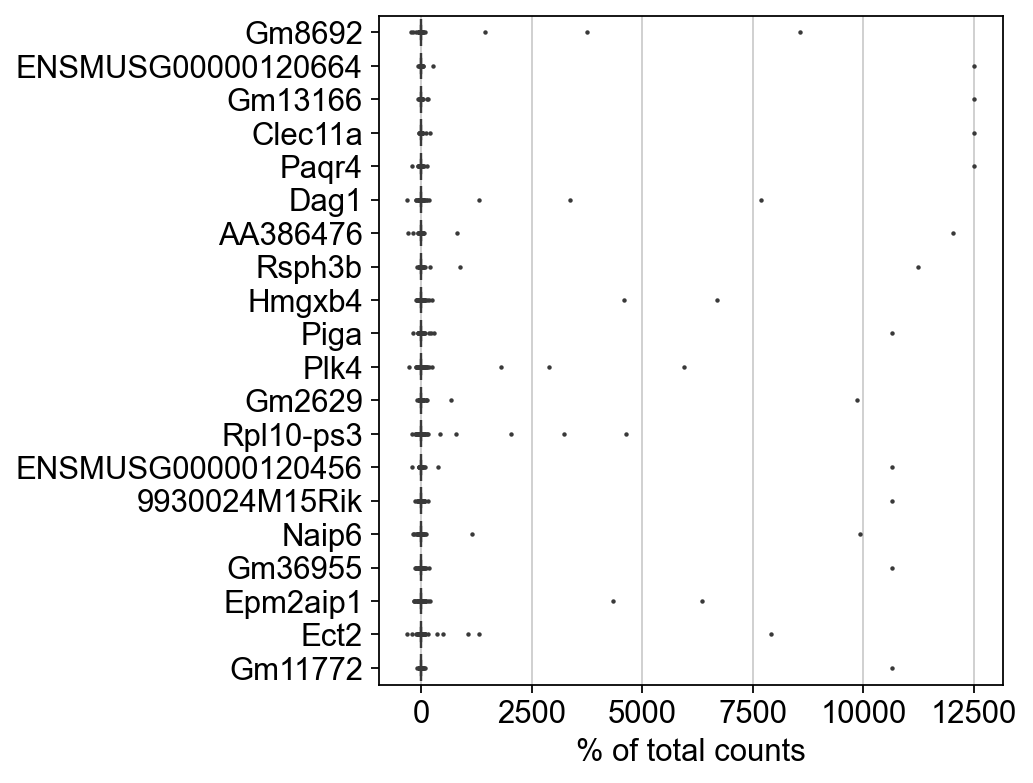

<Figure size 320x320 with 0 Axes>

In [616]:
plotPostNormalization()

#### Principal component analysis:

In [302]:
def plotPCA(adata, n_pcs):
    #Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs = n_pcs)

    #title is not working...
    fig = plt.gcf()
    plt.suptitle(f"PCA Variance Ratio (Top {n_pcs} PCs in sample: {sample_name})", fontsize=16)
    fig.subplots_adjust(top=0.9)
    plt.show()

computing PCA
    with n_comps=50
    finished (0:00:01)


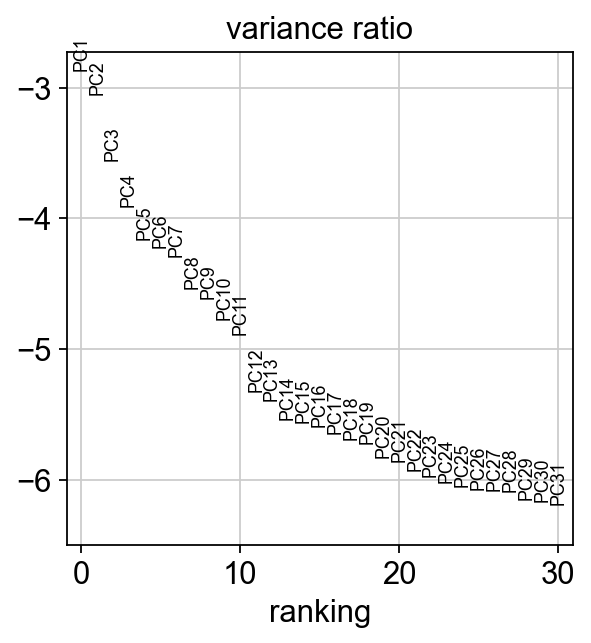

<Figure size 320x320 with 0 Axes>

In [303]:
plotPCA(adata,30)

#### Compute, cluster, and embed the neighborhood graph

In [304]:
def ClusterAnalysis(adata, n_pcs):
    #compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    
    #Embed graph into 2 dimensions using UMAP:
    sc.tl.umap(adata)
    
    #perfom leiden clustering:
    sc.tl.leiden(adata)
    
    #compute ranking for highly expressed genes:
    sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

    return adata

In [305]:
ClusterAnalysis(adata, 40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:35)


AnnData object with n_obs × n_vars = 7119 × 56748
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Plot: Leiden clusters
- function should also plot the names of all 20 most expressed genes

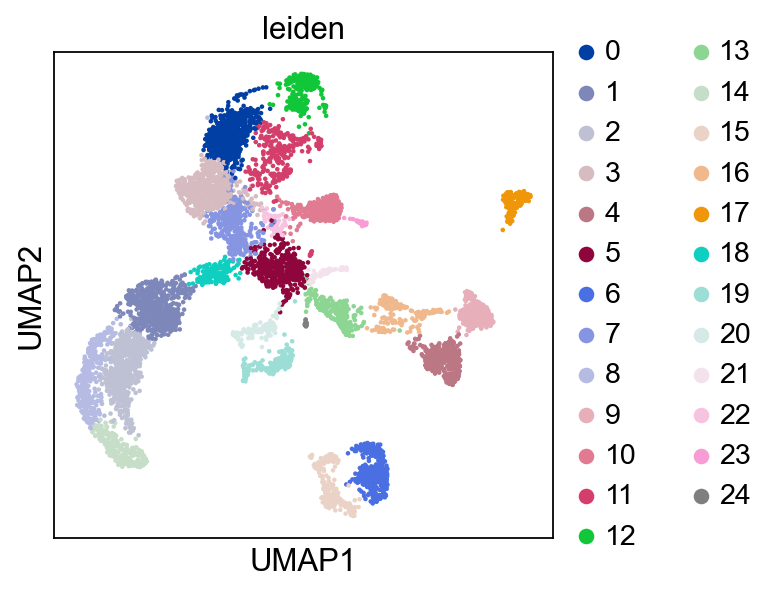

In [306]:
sc.pl.umap(adata, color=['leiden'], wspace=0.33)

In [307]:
   #annotate with scoreCT:
ct.scorect(adata,
          marker_path="./GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.gmt",
          K_top=300,
          m_bins=5,
          null_model='multinomial',
          cluster_key='leiden')

Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  56748
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Marker genes number for Hematopoietic stem cell is too big (n=530) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Monocyte is too big (n=215) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Hematopoietic stem cell is too big (n=530) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Monocyte is too big (n=215) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Hematopoietic stem cell is too big (n=530) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Monocyte is too big (n=215) for multinomial approximation to work. Switching to permutation test.
Marker genes number for Hematopoietic stem cell is too big (n=

In [317]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,scoreCT
AAACCCAAGACCATTC,584,782.0,34.0,4.347826,10,Monocyte
AAACCCAAGGCAGCTA,557,744.0,16.0,2.150538,13,B cell
AAACCCAAGGCAGGGA,1022,2892.0,96.0,3.319502,14,Monocyte
AAACCCAAGGTGGGTT,748,1131.0,27.0,2.387268,22,Monocyte
AAACCCACAACCAATC,321,634.0,4.0,0.630915,2,Monocyte
...,...,...,...,...,...,...
TTTGTTGAGTATAACG,605,834.0,22.0,2.637890,10,Monocyte
TTTGTTGCAAGTCGTT,1387,3309.0,158.0,4.774857,9,Hematopoietic stem cell
TTTGTTGGTCACTAGT,476,653.0,9.0,1.378254,7,Monocyte
TTTGTTGGTGAATATG,134,1115.0,25.0,2.242152,19,Monocyte


In [318]:
def PlotUMAP(adata, color):
    
    sc.pl.umap(adata, color=[color], title=[f"UMAP of: {sample_name}"], use_raw=False,wspace=0.33)

In [ ]:
sc.pl.umap(adata, color=['scoreCT'], title= sample_name, wspace=0.33)

In [425]:
adata2 = sc.read("RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene_results_scoreCT.h5ad")

In [426]:
adata2.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,scoreCT
AAACCCAAGACCATTC,584,782.0,34.0,4.347826,10,Monocyte
AAACCCAAGGCAGCTA,557,744.0,16.0,2.150538,13,B cell
AAACCCAAGGCAGGGA,1022,2892.0,96.0,3.319502,14,Monocyte
AAACCCAAGGTGGGTT,748,1131.0,27.0,2.387268,22,Monocyte
AAACCCACAACCAATC,321,634.0,4.0,0.630915,2,Monocyte
...,...,...,...,...,...,...
TTTGTTGAGTATAACG,605,834.0,22.0,2.637890,10,Monocyte
TTTGTTGCAAGTCGTT,1387,3309.0,158.0,4.774857,9,Hematopoietic stem cell
TTTGTTGGTCACTAGT,476,653.0,9.0,1.378254,7,Monocyte
TTTGTTGGTGAATATG,134,1115.0,25.0,2.242152,19,Monocyte


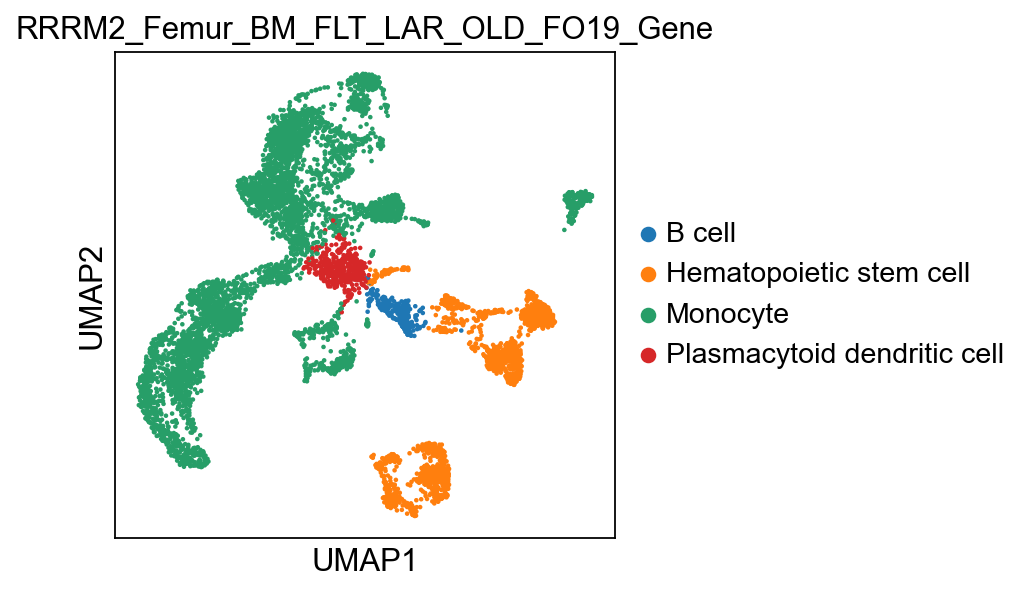

In [427]:
sc.pl.umap(adata2, color=['scoreCT'], title= sample_name, wspace=0.33)

In [661]:
def sc_process(adata, organism, plots, mt_analysis, plot_params=None):
    #perform basic filtering
    BasicFiltering(adata, organism)
    if plots:
        if plot_params is None:
            plot_params = {}
        genes = plot_params.get("genes", [])
        total = plot_params.get("total", None)
        pct_mt = plot_params.get("pct_mt", None)
        mt_counts = plot_params.get("mt_counts", None)
        gene_counts = plot_params.get("gene_counts", None)
        n_pcs = plot_params.get("n_pcs", 10)
        color = plot_params.get("color", "default")
    
        plotCellsAndGenes(adata, organism)
    else:
        n_pcs = 50

    #(Optional: mitochondrial analysis):
    if mt_analysis:
    
        mtAnalysis(adata)
        sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
        print(f"Annotated mitochondrial genes and calculated QC metrics.")
    else:
        sc.pp.calculate_qc_metrics(
        adata, percent_top=None, log1p=False, inplace=True)
        print(f"Calculated QC metrics.")
        
    # Violin and scatter plots):
    if plots:
        plotViolin(adata,genes, total, pct_mt)
        plotScatter(adata, mt_counts, gene_counts)

    if mt_analysis:  
        adata = adata[adata.obs.n_genes_by_counts < 2500, :]
        adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
        print(f"Filtered cells based on gene counts.")
    else:
        adata = adata[adata.obs.n_genes_by_counts < 2500, :]
        print(f"Filtered cells based on gene counts.")
        
    # data normalization:
    Normalization(adata)

    #data regress:
    FilterRegress(adata)
    
    #Plotting Normalization plots and PCA:
    if plots:
        plotPostNormalization(adata)
        plotPCA(adata, n_pcs)

    #perform cluster analysis:
    #Set default number of n_pcs if user decide to not plot data
    if n_pcs is None:
        n_pcs = 50
    ClusterAnalysis(adata, n_pcs)

    #Plotting UMAP:
    if plots:
        PlotUMAP(adata, color)

    print(f"Analysis done!")
    
    return adata